Mean Absolute Error (MAE): 40922.648728461005
Mean Squared Error (MSE): 1877505854.2795866
R^2 Score: 0.9924628810684759


C:\Users\Sukonbu\AppData\Local\Temp\ipykernel_20072\1273626455.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_waste'] = y_test_pred


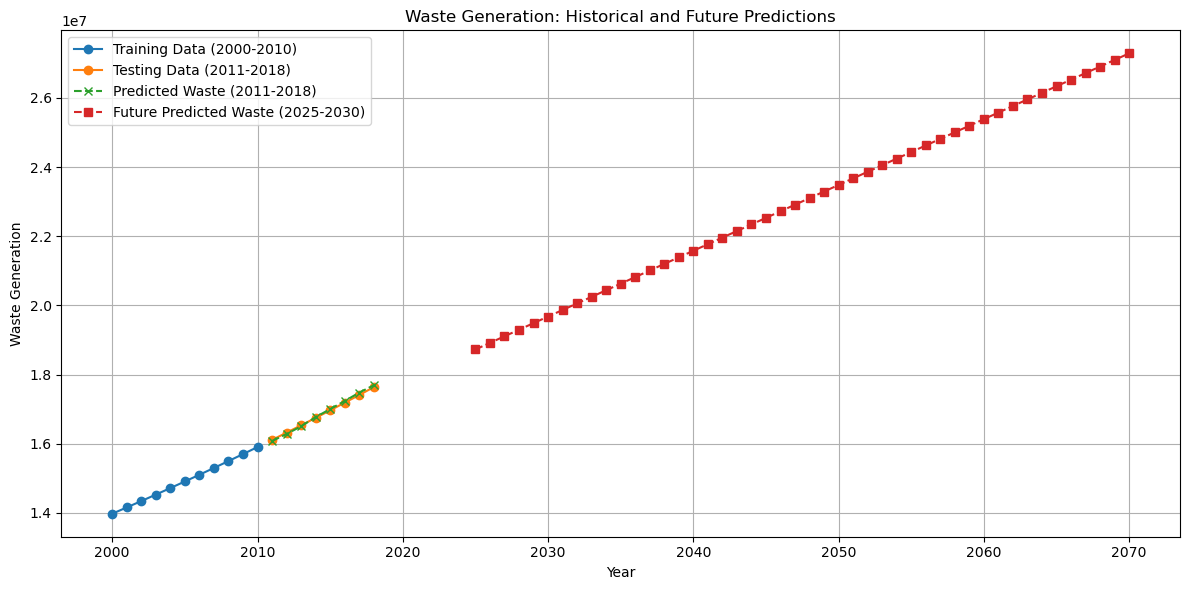

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
data = pd.read_csv('Data/cloneData.csv')

# Split data into training (2000-2010) and testing (2011-2018)
train_data = data[data['year'].between(2000, 2010)]
test_data = data[data['year'].between(2011, 2018)]

# Prepare training and testing sets
X_train = train_data[['year', 'population', 'gdp', 'householdMinIncome', 'death']]
y_train = train_data['waste'].values.reshape(-1, 1)

X_test = test_data[['year', 'population', 'gdp', 'householdMinIncome', 'death']]
y_test = test_data['waste'].values.reshape(-1, 1)

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale training and testing data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Train SVR model with hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.01],
    'epsilon': [0.01, 1]
}

svr = SVR(kernel='linear')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled.ravel())
best_svr = grid_search.best_estimator_

# Predict on test data
y_test_pred_scaled = best_svr.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate predictions
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Train Linear Regression models for each feature to predict future values
feature_models = {}
future_years = pd.DataFrame({'year': list(range(2025, 2071))})

# Predict future feature values
for feature in ['population', 'gdp', 'householdMinIncome', 'death']:
    model = LinearRegression()
    model.fit(train_data[['year']], train_data[feature])
    feature_models[feature] = model
    future_years[feature] = model.predict(future_years[['year']])

# Scale future feature values
future_features_scaled = scaler_X.transform(future_years[['year', 'population', 'gdp', 'householdMinIncome', 'death']])

# Predict waste for future years using SVR
y_future_pred_scaled = best_svr.predict(future_features_scaled)
y_future_pred = scaler_y.inverse_transform(y_future_pred_scaled.reshape(-1, 1)).ravel()

# Add predictions to future_years DataFrame
future_years['predicted_waste'] = y_future_pred

# Save future predictions to CSV
future_years.to_csv('Future_Waste_Predictions_2025_to_2030.csv', index=False)

# Add predictions to the test_data DataFrame
test_data['predicted_waste'] = y_test_pred

# Plot historical vs future predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data['year'], train_data['waste'], label='Training Data (2000-2010)', marker='o')
plt.plot(test_data['year'], test_data['waste'], label='Testing Data (2011-2018)', marker='o')
plt.plot(test_data['year'], test_data['predicted_waste'], label='Predicted Waste (2011-2018)', linestyle='--', marker='x')
plt.plot(future_years['year'], future_years['predicted_waste'], label='Future Predicted Waste (2025-2030)', linestyle='--', marker='s')
plt.title('Waste Generation: Historical and Future Predictions')
plt.xlabel('Year')
plt.ylabel('Waste Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

